In [1]:
!pip install torchviz # just to make nice visualizations of torch model's architectures

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

# Prerequisites for the task

## Homework II ("Training")


1. Implement the train/test loop using the Pytorch library.
* Make neural network as class based on torch.nn.Module.
* The batch size $N_{batch} = 4$.
* Optimization algorithm is Stochastic Gradient Descent, learning rate $\alpha = 0.001$, momentum $\mu = 0.9$.
* Loss function is Mean Squared Error.
* Use $accuracy = \frac{N_{correct}}{N_{total}}$ as a metric to report the quality of model _[practical task, 10% of total score]_.

2. Train the model for $e = 10$ epochs, get the accuracy on test dataset for each 2000 updates, show its evolution by plotting the curve. Write your observations _[practical task, 10% of total score]_.

3. Implement `|| Conv1 ||` operation as a matrix multiplication operation using im2col method. As in HW-1, compare the shapes, outputs, and speed of your implementation and a standard Pytorch one.  _[practical task, 20% of total score]_.

4. Write down the mathematical equations which describe `|| Conv1 ||` layer's forward propagation im2col method. You may present it in a scalar or vector form by your choice. _[theoretical task, 20% of total score]_.

5. You are highly encoraged to comment your thoughts details. The price for quality and completeness of comments for HW-II is _[10% of total score]_.

# Data and imports preparation

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.functional import unfold
from torch.utils.data import TensorDataset, DataLoader

import torchsummary
from torchviz import make_dot
from IPython.display import Image

import time

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import pickle
d = pickle.load(open('cifar10.pkl','rb'))

images_train = d['images_train']
labels_train = d['labels_train']
images_test = d['images_test']
labels_test = d['labels_test']

print('images_train', images_train.shape)
print('labels_train', labels_train.shape)
print('images_test', images_test.shape)
print('labels_test', labels_test.shape)

images_train (50000, 3, 32, 32)
labels_train (50000, 10)
images_test (10000, 3, 32, 32)
labels_test (10000, 10)


# Task 1
Implement the train/test loop using the Pytorch library.
* Make neural network as class based on torch.nn.Module.
* The batch size $N_{batch} = 4$.
* Optimization algorithm is Stochastic Gradient Descent, learning rate $\alpha = 0.001$, momentum $\mu = 0.9$.
* Loss function is Mean Squared Error.
* Use $accuracy = \frac{N_{correct}}{N_{total}}$ as a metric to report the quality of model.

In [5]:
# Baseline net from 1 Howework
class CifarTanhNet(nn.Module):
  def __init__(self):
    super(CifarTanhNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8,
                            kernel_size=3, stride=1, padding=0)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(1800, 100)
    self.fc2 = nn.Linear(100, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)

    x = x.view(x.size(0), -1)

    x = self.fc1(x)
    x = torch.tanh(x)

    x = self.fc2(x)
    x = torch.tanh(x)

    return x

In [6]:
# Initial data is alredy in the right form, all we need is transfer numpy to tensors
# X = (N, C, H, W) size × channels × height × width
# y labels are already in one-hot encoding
X_train = torch.tensor(images_train, dtype=torch.float32)
y_train_oh = torch.tensor(labels_train, dtype=torch.float32)

X_test = torch.tensor(images_test, dtype=torch.float32)
y_test_oh = torch.tensor(labels_test, dtype=torch.float32)

y_train = torch.argmax(y_train_oh, dim=1)
y_test = torch.argmax(y_test_oh, dim=1)

In [8]:
# Dataloader with batch_size=4
train_dataset = TensorDataset(X_train, y_train_oh, y_train)
test_dataset = TensorDataset(X_test, y_test_oh, y_test)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

In [10]:
# Model initialization with SGD optimizer, learning rate = 0.001, momentum = 0.9, and loss function MSE
model = CifarTanhNet()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [11]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
  model.train() # training mode
  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, targets_oh, targets in train_loader:
    optimizer.zero_grad() # clear accumulated gradients
    outputs = model(inputs) # forward pass
    loss = criterion(outputs, targets_oh) # loss MSE
    loss.backward() # backpropagation
    optimizer.step() # update params

    # Accumulate results from each batch
    running_loss += loss.item()
    _, predicted = outputs.max(1) # argmax over output logits to know the actual predicted class
    correct += (predicted == targets).sum().item() # num of correct predictions
    total += targets.size(0)

  acc = correct / total
  print(f"Epoch {epoch+1}: Loss = {running_loss:.4f}, Accuracy = {acc:.4f}")

Epoch 1: Loss = 985.7420, Accuracy = 0.3909
Epoch 2: Loss = 921.8756, Accuracy = 0.4783
Epoch 3: Loss = 900.8601, Accuracy = 0.5017
Epoch 4: Loss = 885.5338, Accuracy = 0.5190
Epoch 5: Loss = 870.7831, Accuracy = 0.5289
Epoch 6: Loss = 855.3903, Accuracy = 0.5403
Epoch 7: Loss = 841.2596, Accuracy = 0.5476
Epoch 8: Loss = 827.0728, Accuracy = 0.5550
Epoch 9: Loss = 813.1538, Accuracy = 0.5639
Epoch 10: Loss = 799.7270, Accuracy = 0.5707


In [12]:
# Estimation on the test set
model.eval() # evaluation mode
correct = 0
total = 0

with torch.no_grad(): # disable gradient calculation
  for inputs, targets_oh, targets in test_loader:
    outputs = model(inputs) # only forward pass
    _, predicted = outputs.max(1)
    correct += (predicted == targets).sum().item()
    total += targets.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.5571


# Task 2

Train the model for $e = 10$ epochs, get the accuracy on test dataset for each 2000 updates, show its evolution by plotting the curve. Write your observations.

In [15]:
# Reinitialization
model = CifarTanhNet()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10
update_interval = 2000
update_counter = 0
test_acc_list = []
update_steps = []

for epoch in range(num_epochs):
  model.train()
  for inputs, targets_oh, targets in train_loader:
    # Same as before training loop
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets_oh)
    loss.backward()
    optimizer.step()

    update_counter += 1

    if update_counter % update_interval == 0: # each 2000 steps (param updates)
      model.eval()
      correct = 0
      total = 0

      # Same as before evaluation on the test set
      with torch.no_grad():
        for test_inputs, test_targets_oh, test_targets in test_loader:
          test_outputs = model(test_inputs)
          _, predicted = test_outputs.max(1)
          correct += (predicted == test_targets).sum().item()
          total += test_targets.size(0)

      acc = correct / total
      print(f"Update {update_counter}: Test Accuracy = {acc:.4f}")

      # Accumulation for the plot
      test_acc_list.append(acc)
      update_steps.append(update_counter)

Update 2000: Test Accuracy = 0.3318
Update 4000: Test Accuracy = 0.3911
Update 6000: Test Accuracy = 0.4206
Update 8000: Test Accuracy = 0.4319
Update 10000: Test Accuracy = 0.4453
Update 12000: Test Accuracy = 0.4652
Update 14000: Test Accuracy = 0.4717
Update 16000: Test Accuracy = 0.4769
Update 18000: Test Accuracy = 0.4776
Update 20000: Test Accuracy = 0.4787
Update 22000: Test Accuracy = 0.4988
Update 24000: Test Accuracy = 0.4952
Update 26000: Test Accuracy = 0.5001
Update 28000: Test Accuracy = 0.5054
Update 30000: Test Accuracy = 0.5079
Update 32000: Test Accuracy = 0.5034
Update 34000: Test Accuracy = 0.5092
Update 36000: Test Accuracy = 0.5155
Update 38000: Test Accuracy = 0.5071
Update 40000: Test Accuracy = 0.5152
Update 42000: Test Accuracy = 0.5201
Update 44000: Test Accuracy = 0.5184
Update 46000: Test Accuracy = 0.5135
Update 48000: Test Accuracy = 0.5232
Update 50000: Test Accuracy = 0.5146
Update 52000: Test Accuracy = 0.5179
Update 54000: Test Accuracy = 0.5171
Updat

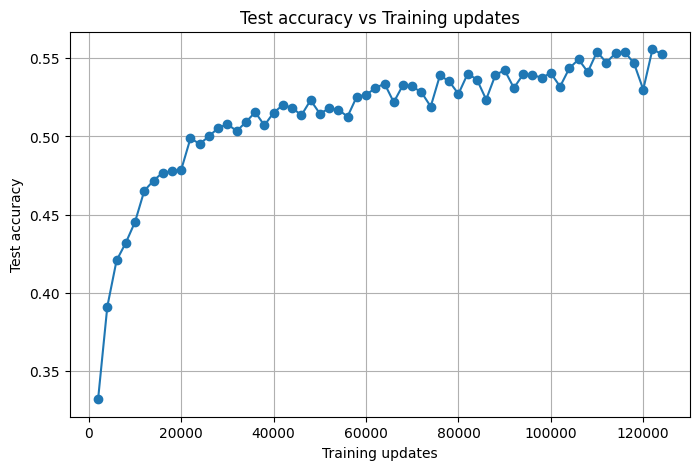

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(update_steps, test_acc_list, marker='o')
plt.title('Test accuracy vs Training updates')
plt.xlabel('Training updates')
plt.ylabel('Test accuracy')
plt.grid(True)
plt.show()

### Observations

Model shows really fast initial learning phase, with accuracy increasing from approximately 33% to 50% within the first 20,000 updates. This suggests it is quickly learning useful representations from the data. After that, the model consistently improves and does not show signs of overfitting.

But the curve continues to improve in a slower pace, and beyond 60,000 updates, the accuracy begins to stabilize around 54–56% with small fluctuations. This plateau means that the model may be approaching its limit or that the learning rate is too low to make further meaningful improvement.

# Task 3

Implement `|| Conv1 ||` operation as a matrix multiplication operation using im2col method. As in HW-1, compare the shapes, outputs, and speed of your implementation and a standard Pytorch one.

In [18]:
def im2col_numpy(input_data, kernel_size, stride):
  N, C, H, W = input_data.shape
  KH, KW = kernel_size
  out_h = (H - KH) // stride + 1 # output spatial dimensions, as no padding provided, the part 2*padding is exluded
  out_w = (W - KW) // stride + 1

  # zero array to hold the im2col patches
  cols = np.zeros((N, C, KH, KW, out_h, out_w))

  for y in range(KH): # slide over image
    for x in range(KW):
      cols[:, :, y, x, :, :] = input_data[:, :, y:y+stride*out_h:stride, x:x+stride*out_w:stride] # extract patches

  # rearrange to (N * out_h * out_w, C * KH * KW)
  cols = cols.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
  return cols

def conv2d_im2col(x, w, b, kernel_size=(3, 3), stride=1):
  N, C, H, W = x.shape
  FN, _, KH, KW = w.shape

  col = im2col_numpy(x, kernel_size, stride)  # ((N * out_h * out_w, C * KH * KW)
  w_col = w.reshape(FN, -1).T  # (C * KH * KW, FN)

  out = col @ w_col  # (N * out_h * out_w, FN) element by elemnt multiplucation
  out = out + b  # add bias
  out_h = (H - KH) // stride + 1 # same dimension formula
  out_w = (W - KW) // stride + 1
  out = out.reshape(N, out_h, out_w, FN).transpose(0, 3, 1, 2)  # (N, FN, out_h, out_w)
  return out

In [24]:
# Dummy input test
x_torch = torch.randn(4, 3, 32, 32)
x_numpy = x_torch.detach().numpy().astype(np.float32)

conv = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
w = conv.weight.detach().numpy().astype(np.float32) # convolution filter tensor (FN=filters, C=input channels, KH=heights, KW=width)
b = conv.bias.detach().numpy().astype(np.float32) # bias (FN,)

# PyTorch version
start = time.time()
y_torch = conv(x_torch)
torch_time = (time.time() - start) * 1000
print("PyTorch output shape:", y_torch.shape)

# NumPy im2col version
start = time.time()
y_numpy = conv2d_im2col(x_numpy, w, b)
numpy_time = (time.time() - start) * 1000
print("NumPy output shape:", y_numpy.shape)

# Comparison
y_torch_np = y_torch.detach().numpy()
diff = np.max(np.abs(y_torch_np - y_numpy))
print(f"Max abs difference between PyTorch vs NumPy: {diff:.10f}")
print(f"PyTorch forward pass time: {torch_time:.3f} ms")
print(f"NumPy forward pass time: {numpy_time:.3f} ms")

PyTorch output shape: torch.Size([4, 8, 30, 30])
NumPy output shape: (4, 8, 30, 30)
Max abs difference between PyTorch vs NumPy: 0.0000006615
PyTorch forward pass time: 0.711 ms
NumPy forward pass time: 0.866 ms


### Observations

Both implementations produced identical output shapes and showed a small maximum absolute difference. So the im2col implementation accurately replicates PyTorch's Conv2D. But PyTorch was slightly faster, due to its optimized C++ backend.

# Task 4

Write down the mathematical equations which describe `|| Conv1 ||` layer's forward propagation im2col method. You may present it in a scalar or vector form by your choice.

Layer parameters:
- Input tensor $\mathbf{X} \in \mathbb{R}^{N \times C \times H \times W}$
- Filters $\mathbf{W} \in \mathbb{R}^{F \times C \times K_h \times K_w}$
- Bias $\mathbf{b} \in \mathbb{R}^{F}$
- Output tensor $\mathbf{Y} \in \mathbb{R}^{N \times F \times H_{\text{out}} \times W_{\text{out}}}$
- Stride $s$
- No padding

Output spatial dimensions $H_{\text{out}} = \left\lfloor \frac{H - K_h}{s} \right\rfloor + 1, \quad W_{\text{out}} = \left\lfloor \frac{W - K_w}{s} \right\rfloor + 1$

Fristly we extract all sliding patches from the input tensor and reshape into a 2D matrix, where each row in $\mathbf{X}_{\text{col}} \in \mathbb{R}^{(N \cdot H_{\text{out}} \cdot W_{\text{out}}) \times (C \cdot K_h \cdot K_w)}$ corresponds to a flattened patch of the input image.

Then we reshape each filter into a column vector and stack them into a matrix $\mathbf{W}_{\text{col}} \in \mathbb{R}^{(C \cdot K_h \cdot K_w) \times F}$.
Each column of $\mathbf{W}_{\text{col}}$ represents a flattened filter for one output channel.

In order to compute all filter responses we do element bu element matrix multiplication:

$$
\mathbf{Z} = \mathbf{X}_{\text{col}} \cdot \mathbf{W}_{\text{col}} + \mathbf{b}
\quad \text{bias $\mathbf{b} \in \mathbb{R}^F$ is broadcasted across all spatial positions}
$$

$$
\mathbf{Z} \in \mathbb{R}^{(N \cdot H_{\text{out}} \cdot W_{\text{out}}) \times F}
$$

These responses must be reshaped back into tensors $\mathbf{Y} = \text{reshape}(\mathbf{Z}) \in \mathbb{R}^{N \times F \times H_{\text{out}} \times W_{\text{out}}}$.

So the sclar looped version for image index $n$, output channel $f$, and position $(i, j)$ is
$$
Y[n, f, i, j] = \sum_{c=0}^{C-1} \sum_{u=0}^{K_h - 1} \sum_{v=0}^{K_w - 1}
X[n, c, i \cdot s + u, j \cdot s + v] \cdot W[f, c, u, v] + b[f]
$$
